# Timeseries anomaly detection using an Autoencoder

**Author:** [pavithrasv](https://github.com/pavithrasv)<br>
**Date created:** 2020/05/31<br>
**Last modified:** 2020/05/31<br>
**Description:** Detect anomalies in a timeseries using an Autoencoder.

## Introduction

This script demonstrates how you can use a reconstruction convolutional
autoencoder model to detect anomalies in timeseries data.

## Setup

In [1]:
import numpy as np
import pandas as pd
import keras
from keras import layers
from matplotlib import pyplot as plt

## Load the data

We will use the [Numenta Anomaly Benchmark(NAB)](
https://www.kaggle.com/boltzmannbrain/nab) dataset. It provides artificial
timeseries data containing labeled anomalous periods of behavior. Data are
ordered, timestamped, single-valued metrics.

We will use the `art_daily_small_noise.csv` file for training and the
`art_daily_jumpsup.csv` file for testing. The simplicity of this dataset
allows us to demonstrate anomaly detection effectively.

In [19]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "realTweets/Twitter_volume_GOOG.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "realTweets/Twitter_volume_FB.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

## Quick look at the data

In [20]:
print(df_small_noise.head())

print(df_daily_jumpsup.head())

                     value
timestamp                 
2015-02-26 21:42:53     35
2015-02-26 21:47:53     41
2015-02-26 21:52:53     32
2015-02-26 21:57:53     36
2015-02-26 22:02:53     32
                     value
timestamp                 
2015-02-26 21:42:53     53
2015-02-26 21:47:53     64
2015-02-26 21:52:53     49
2015-02-26 21:57:53     48
2015-02-26 22:02:53     22


## Visualize the data
### Timeseries data without anomalies

We will use the following data for training.

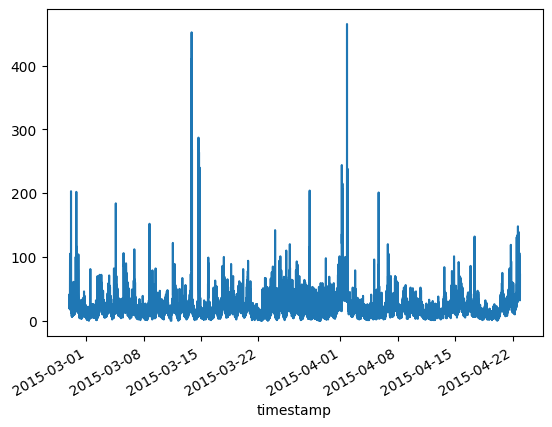

In [21]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

### Timeseries data with anomalies

We will use the following data for testing and see if the sudden jump up in the
data is detected as an anomaly.

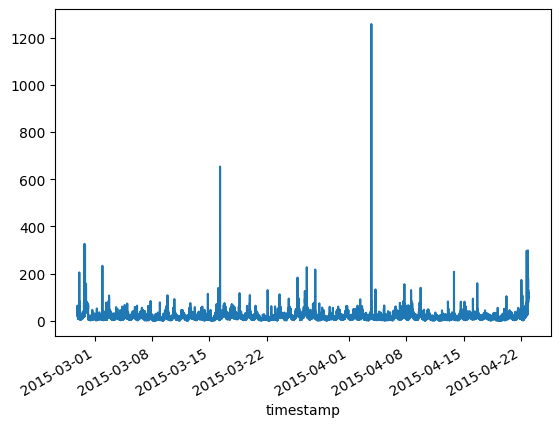

In [22]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

## Prepare training data

Get data values from the training timeseries data file and normalize the
`value` data. We have a `value` for every 5 mins for 14 days.

-   24 * 60 / 5 = **288 timesteps per day**
-   288 * 14 = **4032 data points** in total

In [137]:

TIME_STEPS = 288
cutoff = TIME_STEPS+4

# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()

training_set = df_small_noise[:-cutoff]
testing_set = df_small_noise[-cutoff:]

print(testing_set)

df_training_value = (training_set - training_mean) / training_std
# df_training_value = training_set
print("Number of training samples:", len(df_training_value))

                     value
timestamp                 
2015-04-21 21:32:53     25
2015-04-21 21:37:53     32
2015-04-21 21:42:53     21
2015-04-21 21:47:53     16
2015-04-21 21:52:53     19
...                    ...
2015-04-22 21:27:53     58
2015-04-22 21:32:53     50
2015-04-22 21:37:53     32
2015-04-22 21:42:53     72
2015-04-22 21:47:53     72

[292 rows x 1 columns]
Number of training samples: 15550


### Create sequences
Create sequences combining `TIME_STEPS` contiguous data values from the
training data.

In [139]:


# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    print(len(values))
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])

    return np.stack(output)

# print(len(df_training_value))
# print(len(df_training_value[:-50]))
# print(len(df_training_value[-50:]))

# training_arr = df_training_value[:-50]
# testing_arr = df_training_value[-50:]

# print(testing_arr.values)
# print(df_training_value.values)

x_train = create_sequences(df_training_value.values)
x_test = create_sequences(testing_set.values)

# print(x_train[0].flatten())
# print(x_test[0].flatten())

print("Training input shape: ", x_train.shape)
print("Testing input shape: ", x_test.shape)

15550
292
Training input shape:  (15263, 288, 1)
Testing input shape:  (5, 288, 1)


## Build a model

We will build a convolutional reconstruction autoencoder model. The model will
take input of shape `(batch_size, sequence_length, num_features)` and return
output of the same shape. In this case, `sequence_length` is 288 and
`num_features` is 1.

In [140]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Conv1DTranspose(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 144, 32)           256       
                                                                 
 dropout_24 (Dropout)        (None, 144, 32)           0         
                                                                 
 conv1d_25 (Conv1D)          (None, 72, 16)            3600      
                                                                 
 conv1d_transpose_36 (Conv1  (None, 144, 16)           1808      
 DTranspose)                                                     
                                                                 
 dropout_25 (Dropout)        (None, 144, 16)           0         
                                                                 
 conv1d_transpose_37 (Conv1  (None, 288, 32)           3616      
 DTranspose)                                         

## Train the model

Please note that we are using `x_train` as both the input and the target
since this is a reconstruction model.

In [141]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=256,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
54/54 [==============================] - 3s 13ms/step - loss: 0.5623 - val_loss: 0.1112
Epoch 2/50
54/54 [==============================] - 0s 7ms/step - loss: 0.2067 - val_loss: 0.0529
Epoch 3/50
54/54 [==============================] - 0s 7ms/step - loss: 0.1191 - val_loss: 0.0256
Epoch 4/50
54/54 [==============================] - 0s 7ms/step - loss: 0.0897 - val_loss: 0.0165
Epoch 5/50
54/54 [==============================] - 0s 7ms/step - loss: 0.0774 - val_loss: 0.0136
Epoch 6/50
54/54 [==============================] - 0s 7ms/step - loss: 0.0701 - val_loss: 0.0116
Epoch 7/50
54/54 [==============================] - 0s 7ms/step - loss: 0.0651 - val_loss: 0.0109
Epoch 8/50
54/54 [==============================] - 0s 7ms/step - loss: 0.0612 - val_loss: 0.0096
Epoch 9/50
54/54 [==============================] - 0s 7ms/step - loss: 0.0580 - val_loss: 0.0090
Epoch 10/50
54/54 [==============================] - 0s 7ms/step - loss: 0.0553 - val_loss: 0.0087
Epoch 11/50
54/54 

Let's plot training and validation loss to see how the training went.

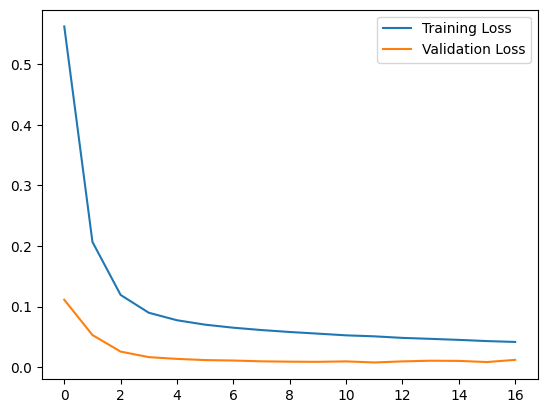

In [142]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## Detecting anomalies

We will detect anomalies by determining how well our model can reconstruct
the input data.


1.   Find MAE loss on training samples.
2.   Find max MAE loss value. This is the worst our model has performed trying
to reconstruct a sample. We will make this the `threshold` for anomaly
detection.
3.   If the reconstruction loss for a sample is greater than this `threshold`
value then we can infer that the model is seeing a pattern that it isn't
familiar with. We will label this sample as an `anomaly`.


1/1 [==============================] - 0s 136ms/step


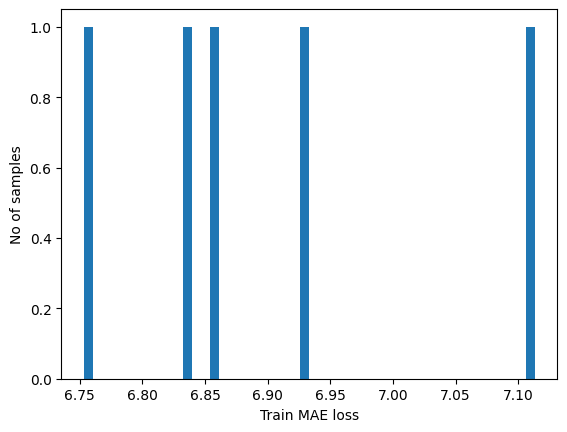

Reconstruction error threshold:  7.113060865137312


In [143]:
# Get train MAE loss.
# print(x_test)
x_test_pred = model.predict(x_test)
train_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

### Compare recontruction

Just for fun, let's see how our model has recontructed the first sample.
This is the 288 timesteps from day 1 of our training dataset.

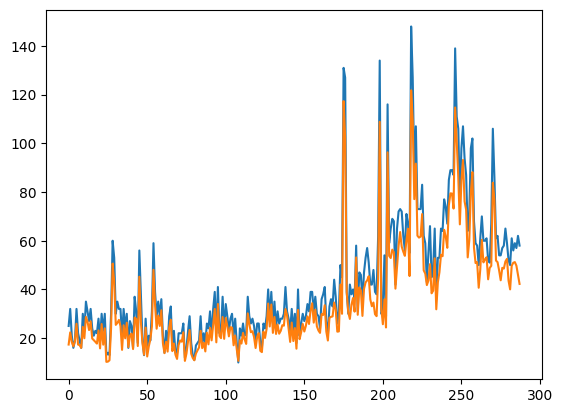

In [144]:
# Checking how the first sequence is learnt
# print(x_train)
plt.plot(x_test[0])
plt.plot(x_test_pred[0])
plt.show()

In [145]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print(x_test.shape, len(x_test.flatten()))

mae = mean_absolute_error(x_test.flatten(), x_test_pred.flatten())
mse = mean_squared_error(x_test.flatten(), x_test_pred.flatten())
rmse = np.sqrt(mse)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

(5, 288, 1) 1440
Mean Absolute Error: 6.8981
Mean Squared Error: 72.2155
Root Mean Squared Error: 8.4980


### Prepare test data

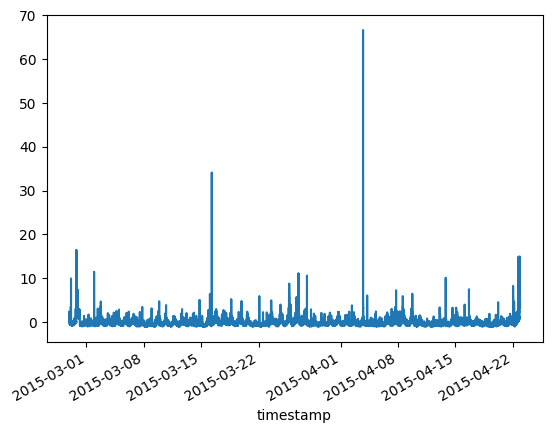

[[1.73790746]
 [2.33043216]
 [1.52244393]
 ...
 [5.99331218]
 [3.08455452]
 [5.18532394]]
Test input shape:  (15833, 1, 1)
495/495 [==============================] - 1s 2ms/step


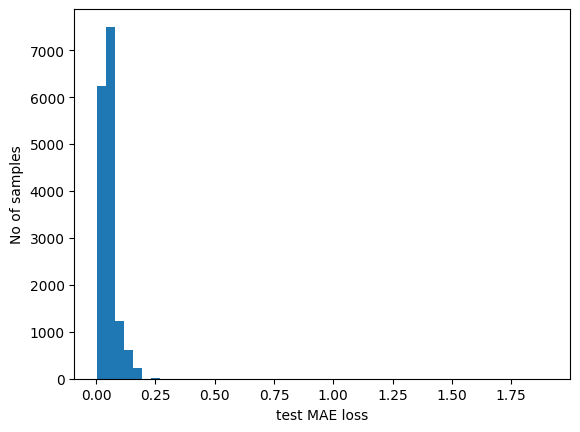

Number of anomaly samples:  3
Indices of anomaly samples:  (array([ 5009, 10320, 10321]),)


In [54]:

df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

## Plot anomalies

We now know the samples of the data which are anomalies. With this, we will
find the corresponding `timestamps` from the original test data. We will be
using the following method to do that:

Let's say time_steps = 3 and we have 10 training values. Our `x_train` will
look like this:

- 0, 1, 2
- 1, 2, 3
- 2, 3, 4
- 3, 4, 5
- 4, 5, 6
- 5, 6, 7
- 6, 7, 8
- 7, 8, 9

All except the initial and the final time_steps-1 data values, will appear in
`time_steps` number of samples. So, if we know that the samples
[(3, 4, 5), (4, 5, 6), (5, 6, 7)] are anomalies, we can say that the data point
5 is an anomaly.

In [32]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

Let's overlay the anomalies on the original test data plot.

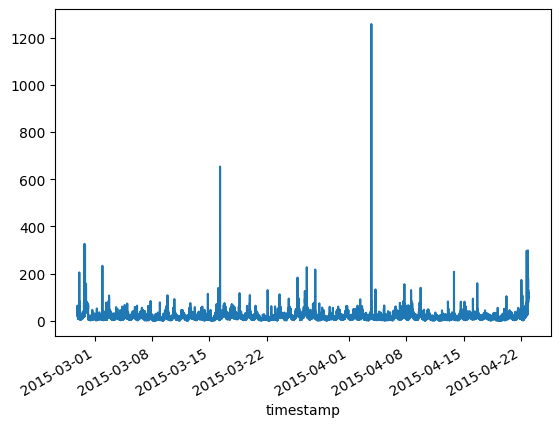

In [33]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()